# Подключение библиотеки

In [1]:
import timeit
import time
import sys
import os
import re
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm.auto import tqdm
from IPython.display import display, HTML, Markdown
from datetime import datetime
from mermaid import Mermaid
import matplotlib.pyplot as plt

# Метрики
from sklearn.metrics import mean_squared_error

# Нейросети
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
# Для сборщика мусора
import gc

In [2]:
try:
    from torchdiffeq import odeint  # Импортируем ODE-решатель
    from TorchDiffEqPack.odesolver import odesolve  # Заменяем пакет решателей ODE
except:
    !pip install torchdiffeq
    !pip install TorchDiffEqPack

    from torchdiffeq import odeint  # Импортируем ODE-решатель
    from TorchDiffEqPack.odesolver import odesolve  # Заменяем пакет решателей ODE

# Импорт и анализ данных

In [3]:
try:
    df = pd.read_csv('Amp_C_train.txt')
except:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            
    df = pd.read_csv(os.path.join(dirname, filename))

##### Рассмотрим содержимое датасет

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172032 entries, 0 to 172031
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    172032 non-null  float64
 1   Input   172032 non-null  object 
 2   Output  172032 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


# Машинное обучение

In [5]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Device name: NVIDIA GeForce GTX 1650 Ti
CUDA capability: (7, 5)
Driver version: 12.1
Device count: 1
Current device: 0


### Neural Ordinary Differential Equations (Neural ODE)

#### Инициализация класса модели

In [115]:
# Класс для обучения и оценки модели Neural ODE
class NeuralODETrainer:
    def __init__(self, df, batch_size=64, learning_rate=0.001, epochs=10, hidden_layers=[64, 128, 256, 128], method='dopri5'):
        # Преобразуем данные
        self.df = self.prepare_data(df)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.hidden_layers = hidden_layers
        self.method = method
        self.history = {"epoch": [], "rmse": []}  # История обучения

        # Подготовка данных
        self.dataset = TensorDataset(
            torch.tensor(self.df.index.values, dtype=torch.float32),
            torch.tensor(self.df[['input_real', 'input_imag']].values, dtype=torch.float32),
            torch.tensor(self.df[['output_real', 'output_imag']].values, dtype=torch.float32),
        )
        self.train_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, pin_memory=True)
        
        # Инициализация модели
        self.model = self.NeuralODEModel(hidden_layers=self.hidden_layers).to(self.get_device())
        self.criterion = nn.MSELoss()  # Используем MSE как функцию потерь
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    # Метод для преобразования данных в нужный формат
    @staticmethod
    def prepare_data(df):
        df['Input'] = df['Input'].apply(lambda x: complex(x))  # Преобразуем строки в комплексные числа
        df['Output'] = df['Output'].apply(lambda x: complex(x))
        df['input_real'] = df['Input'].apply(lambda x: x.real)
        df['input_imag'] = df['Input'].apply(lambda x: x.imag)
        df['output_real'] = df['Output'].apply(lambda x: x.real)
        df['output_imag'] = df['Output'].apply(lambda x: x.imag)
        df = df.drop(['Input', 'Output'], axis=1)
        df = df.set_index('Time')  # Устанавливаем временной ряд как индекс
        return df

    # Класс ODE функции
    # class ODEFunc(nn.Module):
    #     def __init__(self, hidden_size):
    #         super().__init__()
    #         self.linear = nn.Linear(hidden_size, hidden_size)
    #         self.relu = nn.ReLU()

    #     def forward(self, t, x):
    #         return self.relu(self.linear(x))

    class ODEFunc(nn.Module):
        def __init__(self, hidden_size):
            super().__init__()
            self.fc1 = nn.Linear(hidden_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.relu = nn.ReLU()
            self.norm = nn.LayerNorm(hidden_size)  # Добавляем нормализацию
    
        def forward(self, t, x):
            x = self.relu(self.fc1(x))
            x = self.norm(x)  # Применяем нормализацию
            return self.relu(self.fc2(x))

    # Класс модели Neural ODE
    class NeuralODEModel(nn.Module):
        def __init__(self, input_size=2, hidden_layers=[128], output_size=2):
            super().__init__()
            self.input_layer = nn.Linear(input_size, hidden_layers[0])
            
            self.hidden_layers = nn.ModuleList([])
            self.residual_connections = nn.ModuleList([]) # Добавляем список для преобразований residual
            for i in range(len(hidden_layers) - 1):
                self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
                # Линейное преобразование для residual, если размерности не совпадают
                if hidden_layers[i] != hidden_layers[i + 1]: 
                    self.residual_connections.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
                else:
                    self.residual_connections.append(nn.Identity()) # Идентичное преобразование, если размерности совпадают
    
            self.ode_func = NeuralODETrainer.ODEFunc(hidden_layers[-1])
            self.output_layer = nn.Linear(hidden_layers[-1], output_size)
            self.dropout = nn.Dropout(p=0.5)

        def forward(self, x, t):
            x = self.input_layer(x)
            for layer, residual_layer in zip(self.hidden_layers, self.residual_connections): # Итерируемся по слоям и преобразованиям
                residual = x
                x = torch.relu(layer(x)) 
                x = self.dropout(x)
                x += residual_layer(residual)  # Применяем преобразование к residual перед сложением
                
            options = {
                'method': 'dopri5',  # метод решения (адаптивный шаг)
                't0': t[0].item(),  # начальное время
                't1': t[-1].item(),  # конечное время
                'rtol': 1e-9,  # относительная точность
                'atol': 1e-10,  # абсолютная точность
                'print_neval': False,  # не выводить количество итераций
                'neval_max': 1e7,  # максимальное число итераций
                't_eval': t[-1:],  # Берем только последний элемент t
                'regenerate_graph': False  # не перегенерировать граф для обратного прохода
            }
            
            x = odesolve(self.ode_func, x, options=options)
            x = x.squeeze(0)  # Удаляем первую размерность
            x = self.output_layer(x)

            assert x.shape[1] == 2, f"Error: 2 output values are expected, received {x.shape[1]}"

            return x

    # Метод для получения устройства (CPU или GPU)
    @staticmethod
    def get_device():
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def train(self):
        device = self.get_device()
        self.model.train()
    
        for epoch in range(self.epochs):
            running_loss = 0.0
            rmse_total = 0.0
            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs}", unit="batch")
    
            for batch_idx, (t, inputs, targets) in enumerate(progress_bar):
                inputs, targets = inputs.to(device), targets.to(device)
                t = t.to(device)
                self.optimizer.zero_grad()
    
                outputs = self.model(inputs, t)
                loss = self.criterion(outputs, targets)
                rmse = torch.sqrt(loss)  # RMSE
                rmse.backward()
                self.optimizer.step()
    
                # Рассчитываем RMSE
                rmse_total += rmse.item()
    
                progress_bar.set_postfix(rmse=f"{rmse:.6f}")
    
            avg_rmse = rmse_total / len(self.train_loader)
            
            # Сохраняем метрики в историю
            self.history["epoch"].append(epoch + 1)
            self.history["rmse"].append(avg_rmse)
    
            print(f"Epoch {epoch+1}/{self.epochs} completed with RMSE: {avg_rmse:.6f}")
    
        print("Training completed!")
        self.save_training_history(self.history)

    # Метод для оценки модели
    def evaluate(self):
        self.model.eval()
        true_values = []
        predicted_values = []
        times = []
        device = self.get_device()
    
        with torch.no_grad():
            for t, inputs, targets in self.train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                t = t.to(device)
                outputs = self.model(inputs, t)
                true_values.append(targets.cpu().numpy())
                predicted_values.append(outputs.cpu().numpy())
                times.append(t.cpu().numpy())
    
        # Конкатенация всех предсказанных значений, истинных значений и временных меток
        self.true_values = np.concatenate(true_values, axis=0)
        self.predicted_values = np.concatenate(predicted_values, axis=0)
        self.times = np.concatenate(times, axis=0)
    
        # Сортировка данных по временам
        sort_indices = np.argsort(self.times)
        self.times = self.times[sort_indices]
        self.true_values = self.true_values[sort_indices]
        self.predicted_values = self.predicted_values[sort_indices]
            
        # Проверяем размерности и удаляем лишние, если необходимо
        if len(self.true_values.shape) == 3 and self.true_values.shape[1] == 1:
            self.true_values = self.true_values.squeeze(1)
        if len(self.predicted_values.shape) == 3 and self.predicted_values.shape[1] == 1:
            self.predicted_values = self.predicted_values.squeeze(1)
    
        # Проверяем размерности после удаления лишних размерностей
        assert self.true_values.shape[1] == 2, f"True values should have shape (n_samples, 2), but got {self.true_values.shape}"
        assert self.predicted_values.shape[1] == 2, f"Predicted values should have shape (n_samples, 2), but got {self.predicted_values.shape}"

        # Сохраним предсказанные значения
        self.save_prediction(self.predicted_values)
        # Сохраним модель
        self.save_model(self.model)

        # Вычисление RMSE
        rmse_real = mean_squared_error(self.true_values[:, 0], self.predicted_values[:, 0], squared=False)
        rmse_imag = mean_squared_error(self.true_values[:, 1], self.predicted_values[:, 1], squared=False)

        print(f"Evaluation RMSE (Real): {rmse_real:.6f}")
        print(f"Evaluation RMSE (Imaginary): {rmse_imag:.6f}")
    
        return rmse_real, rmse_imag

    @staticmethod
    def save_model(model, filename_prefix='node', save_dir='models'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.pth"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)

        # Сохраняем ВСЮ модель
        torch.save(model.state_dict(), filepath)

    @staticmethod
    def save_prediction(predictions, filename_prefix="predictions", save_dir='history'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_predictions = pd.DataFrame({'real': predictions[:, 0], 'imag': predictions[:, 1],})
        df_predictions.to_csv(filepath, index=False)
        print(f"Training history saved to {filepath}")

    @staticmethod
    def save_training_history(history, filename_prefix="training_history", save_dir='history'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_history = pd.DataFrame(history)
        df_history.to_csv(filepath, index=False)
        print(f"Training history saved to {filepath}")

    def plot_training_history(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
    
        # Первый график: Полная история
        axs[0].plot(epochs, self.history["rmse"], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()

        # Второй график: Половина истории
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], self.history["rmse"][mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average RMSE')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, time_start=0, time_end=1.005e2):
        # Убедимся, что данные были вычислены в evaluate()
        if not hasattr(self, 'true_values') or not hasattr(self, 'predicted_values') or not hasattr(self, 'times'):
            raise ValueError("You must run evaluate() before plotting predictions.")
    
        # Фильтрация данных по времени
        mask = (self.times >= time_start) & (self.times <= time_end)
        filtered_times = self.times[mask]
        filtered_true_values = self.true_values[mask, :]  
        filtered_predicted_values = self.predicted_values[mask, :]
    
        # Построение графика для реальных значений
        plt.figure(figsize=(20, 5))
    
        plt.subplot(1, 2, 1)  # 1 ряд, 2 колонки, 1-й график
        plt.plot(filtered_times, filtered_true_values[:, 0], label="True Real", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_predicted_values[:, 0], label="Predicted Real", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Real Values")
        plt.xlabel("Time")
        plt.ylabel("Real Value")
    
        # Построение графика для мнимых значений
        plt.subplot(1, 2, 2)  # 1 ряд, 2 колонки, 2-й график
        plt.plot(filtered_times, filtered_true_values[:, 1], label="True Imag", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_predicted_values[:, 1], label="Predicted Imag", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Imaginary Values")
        plt.xlabel("Time")
        plt.ylabel("Imaginary Value")
    
        plt.tight_layout()
        plt.show()

    def print_model_summary(self, filename_prefix="model_parameters", save_dir='history'):
        """
        Выводит информацию о модели: архитектуру, параметры и их размерности.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_params = pd.DataFrame(columns=['Parameter name', 'Parameter shape', 'Parameter count'])
        
        print(f"Model architecture: {self.model}")
        print("-" * 50)

        total_params = 0
        for name, param in self.model.named_parameters():
            print(f"Parameter name: {name}")
            print(f"Parameter shape: {param.shape}")
            param_count = torch.numel(param)
            print(f"Parameter count: {param_count}")
            print("-" * 30)

            # Добавляем информацию о параметре в DataFrame
            df_params.loc[len(df_params)] = [name, param.shape, param_count] 
            
            total_params += param_count

        print(f"Total trainable parameters: {total_params}")
        print("=" * 50)
        
        # Сохраняем DataFrame в CSV файл
        df_params.to_csv(filepath, index=False)

#### Установка параметров

In [116]:
batch_size=1024*5
learning_rate=1e-4
epochs=2
# layers=[64, 128, 256, 128]
layers=[64]

In [117]:
# Создание экземпляра класса с настройкой гиперпараметров
NODE_model = NeuralODETrainer(df, batch_size, learning_rate, epochs, layers)

In [118]:
NODE_model.print_model_summary()

Model architecture: NeuralODEModel(
  (input_layer): Linear(in_features=2, out_features=64, bias=True)
  (hidden_layers): ModuleList()
  (residual_connections): ModuleList()
  (ode_func): ODEFunc(
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (relu): ReLU()
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
--------------------------------------------------
Parameter name: input_layer.weight
Parameter shape: torch.Size([64, 2])
Parameter count: 128
------------------------------
Parameter name: input_layer.bias
Parameter shape: torch.Size([64])
Parameter count: 64
------------------------------
Parameter name: ode_func.fc1.weight
Parameter shape: torch.Size([64, 64])
Parameter count: 4096
------------------------------
Parameter name: ode_func.fc1.bias
Parameter shape: torch.S

#### Обучение модели

In [10]:
%%time
NODE_model.train()

Epoch 1/2:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 1/2 completed with RMSE: 2.127397


Epoch 2/2:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 2/2 completed with RMSE: 2.080800
Training completed!
Training history saved to history/training_history_20241009_190948.csv
CPU times: user 9.28 s, sys: 1.3 s, total: 10.6 s
Wall time: 7.13 s


In [11]:
# NODE_model.plot_training_history()

#### Предсказание и сохранение модели после обучения

In [12]:
%%time
NODE_model.evaluate()

Training history saved to history/predictions_20241009_190951.csv
Evaluation RMSE (Real): 2.040729
Evaluation RMSE (Imaginary): 2.073226
CPU times: user 5.11 s, sys: 595 ms, total: 5.7 s
Wall time: 3.08 s


(2.0407286, 2.073226)

#### Демонстрация

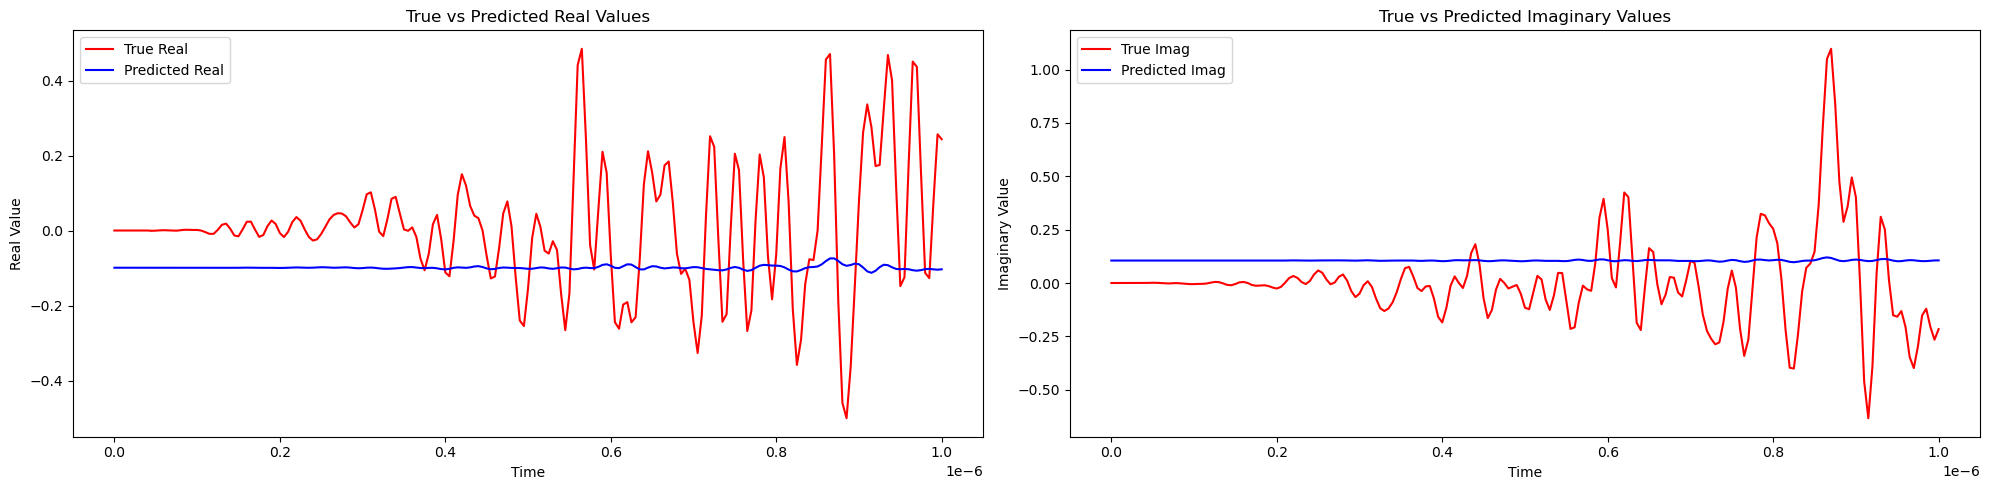

CPU times: user 239 ms, sys: 6.11 ms, total: 245 ms
Wall time: 243 ms


In [13]:
%%time
NODE_model.plot_predictions(time_start=0, time_end=0.1e-5)

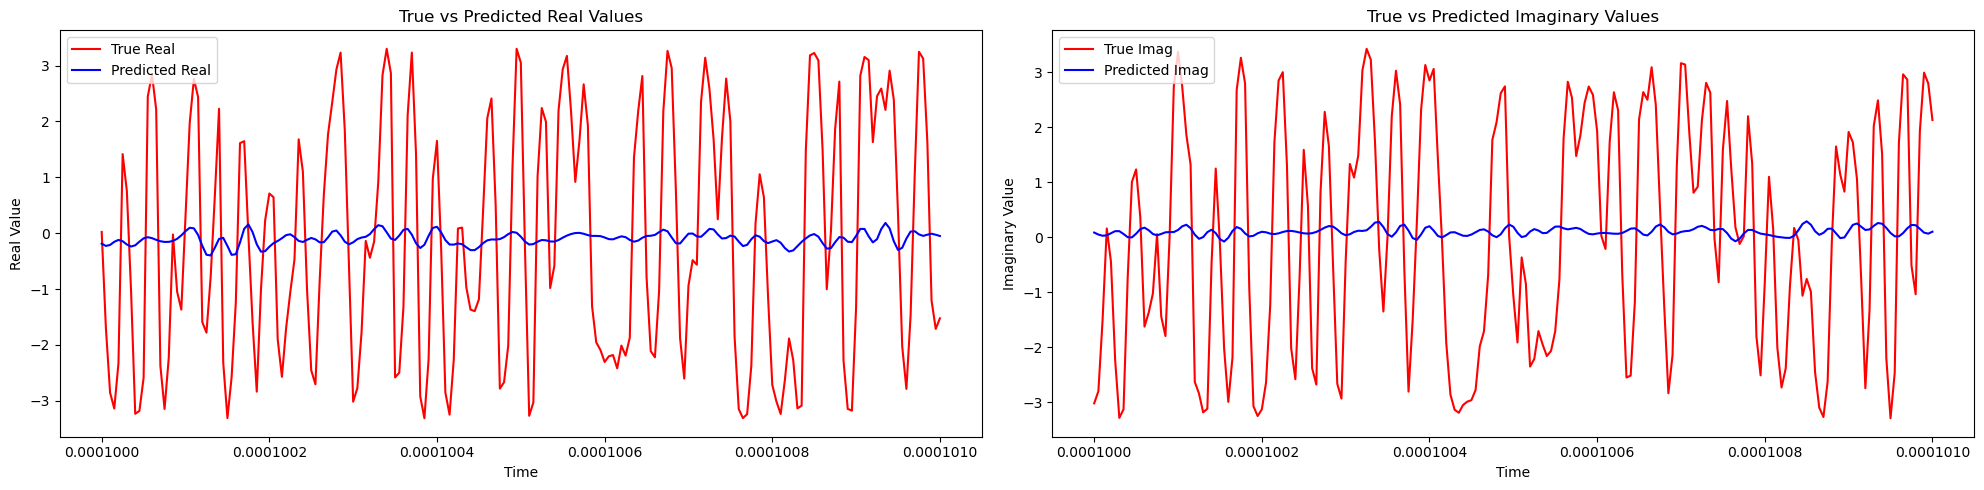

CPU times: user 252 ms, sys: 7.07 ms, total: 259 ms
Wall time: 257 ms


In [14]:
%%time
NODE_model.plot_predictions(time_start=1e-4, time_end=1.01e-4)

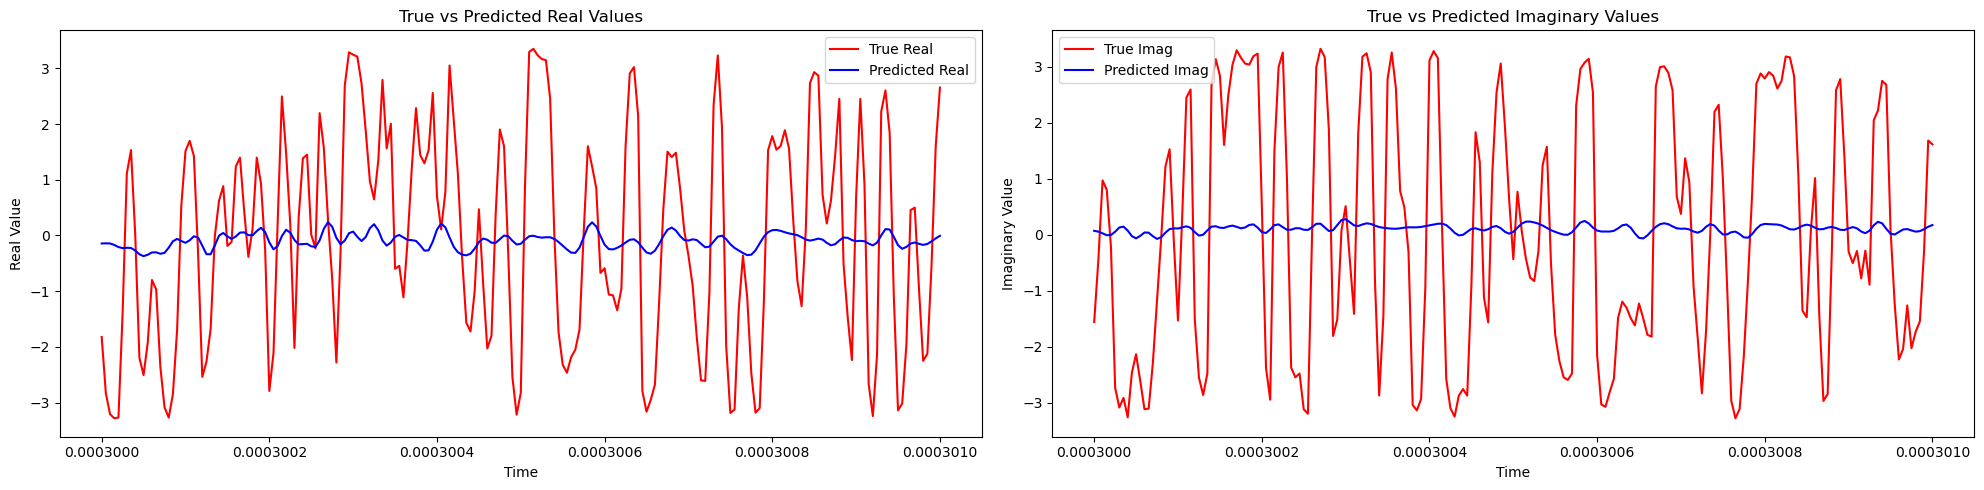

CPU times: user 251 ms, sys: 4.06 ms, total: 255 ms
Wall time: 253 ms


In [15]:
%%time
NODE_model.plot_predictions(time_start=3e-4, time_end=3.01e-4)

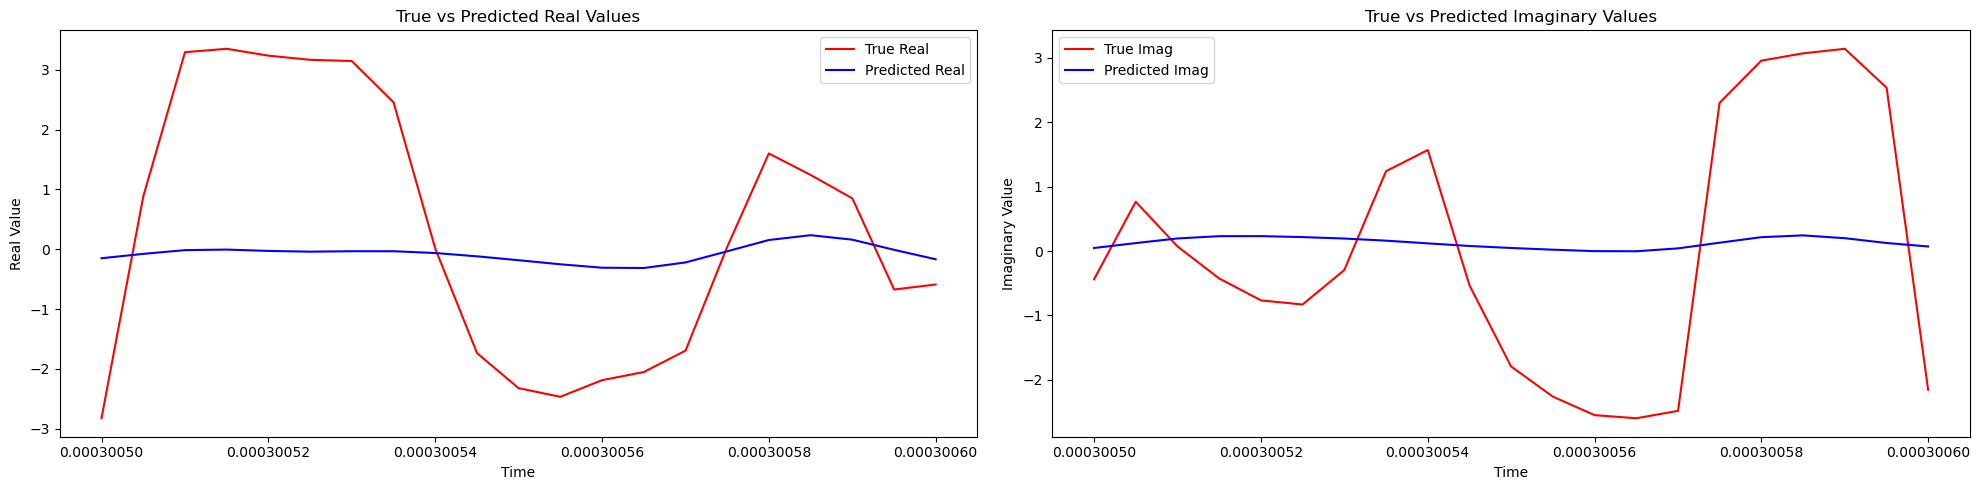

CPU times: user 233 ms, sys: 5.13 ms, total: 238 ms
Wall time: 236 ms


In [16]:
%%time
NODE_model.plot_predictions(time_start=3.005e-4, time_end=3.006e-4)

# Исследование и результаты обучения с Kaggle

In [228]:
df_results = pd.DataFrame(columns=['Total parameters', 'RMSE', 'Training time (s)'])
df_results = df_results.astype({'Total parameters': 'int', 'RMSE': 'float', 'Training time (s)': 'float'}) 

##### Тут будут приведены исследования с Kaggle.
##### В данном исследовании будут демонстрировать историю обучения, которая прошла успешно и неуспешно. Обучение произвели неуспешно, потому что было прерваны из-за превышения лимита по обучению. Из-за прерывания нам не удалось сохранить ход обучения в csv и модель, поэтому будем опираться на log.

## Вспомогательные функции

### Парсинг архитектуры модели

In [258]:
def parse_model_architecture(log_file):
  """
  Парсит файл .log и извлекает архитектуру модели.

  Args:
    log_file: Путь к файлу .log.

  Returns:
    Строка, содержащая архитектуру модели, или None, если она не найдена.
  """
  with open(log_file, "r") as f:
    log_content = f.read()

# Найти начало и конец архитектуры модели в логе
  match = re.search(r"Model architecture:(.*?)-{10,}", log_content, re.DOTALL)
  if match:
    architecture_str = match.group(1).strip()
    # Удалить временные метки в начале каждой строки
    cleaned_architecture = "\n".join([re.sub(r"^\d+\.\d+s \d+ ", "", line) for line in architecture_str.split("\n")])
    return cleaned_architecture 
  else:
    return None

### Парсинг параметры модели

In [259]:
def parse_model_parameters(log_file):
  """
  Парсит файл .log и извлекает информацию о параметрах модели, 
  включая общее количество обучаемых параметров.

  Args:
    log_file: Путь к файлу .log.

  Returns:
    Словарь, где ключи - имена параметров, а значения - словари с информацией
    о форме и количестве элементов параметра. Также включает ключ 'total_parameters' 
    с общим количеством обучаемых параметров.
    Например:
    {
      'input_layer.weight': {'shape': 'torch.Size([1024, 2])', 'count': 2048},
      'input_layer.bias': {'shape': 'torch.Size([1024])', 'count': 1024},
      ...
      'total_parameters': 572603394 
    }
  """
  parameters = {}
  with open(log_file, "r") as f:
    for line in f:
      match = re.search(r"Parameter name: (.*)", line)
      if match:
        param_name = match.group(1).strip()
        parameters[param_name] = {}
      match = re.search(r"Parameter shape: (.*)", line)
      if match:
        parameters[param_name]['shape'] = match.group(1).strip()
      match = re.search(r"Parameter count: (\d+)", line)
      if match:
        parameters[param_name]['count'] = int(match.group(1))
      match = re.search(r"Total trainable parameters: (\d+)", line)
      if match:
        parameters['total_parameters'] = int(match.group(1))
  return parameters

### Парсинг истории обучения

In [260]:
def parse_training_history(log_file):
    """
    Парсит файл .log, извлекает историю обучения 
    и вычисляет общее время обучения.

    Args:
      log_file: Путь к файлу .log.

    Returns:
      tuple: (pandas.DataFrame, total_training_time)
        - pandas.DataFrame с колонками "Epoch" и "RMSE", 
          или None, если история обучения не найдена.
        - total_training_time (float): Общее время обучения в секундах, 
          или None, если не найдено.
    """
    epochs = []
    rmses = []
    total_training_time = None
    start_time = None
    end_time = None

    with open(log_file, "r") as f:
        lines = f.readlines()

        for line in lines:
            # Ищем "Wall time" внутри цикла
            match_time = re.search(r"Wall time: (\d+)min (\d+)s", line)
            if match_time:
                minutes = int(match_time.group(1))
                seconds = int(match_time.group(2))
                total_training_time = minutes * 60 + seconds
                # Если нашли "Wall time", больше не ищем время начала/окончания
                break 

            # Поиск начала обучения, если "Wall time" не найден
            if total_training_time is None:
                match_start = re.search(r"([\d\.]+)s \d+ ==================================================", line)
                if match_start and start_time is None:
                    start_time = float(match_start.group(1))

            # Поиск информации об эпохе и RMSE
            match_epoch = re.search(r"Epoch (\d+)/\d+ completed with RMSE: ([\d\.]+)", line)
            if match_epoch:
                epochs.append(int(match_epoch.group(1)))
                rmses.append(float(match_epoch.group(2)))

            # Поиск времени окончания обучения (последняя строка лога)
            match_end = re.search(r"^([\d\.]+)s", line.strip())
            if match_end and total_training_time is None:
                end_time = float(match_end.group(1))

        # Если total_training_time не найден с помощью "Wall time", 
        # вычисляем разницу между временем начала и окончания
        if total_training_time is None and start_time is not None and end_time is not None:
            total_training_time = end_time - start_time 

    if epochs and rmses:
        df_history = pd.DataFrame({"Epoch": epochs, "RMSE": rmses})
        return df_history, total_training_time 
    else:
        return None, None

### Иллюстрация график обучения

In [261]:
def plot_training_history(df):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Преобразуем список эпох для оси X
    epochs = df["Epoch"]
    rmse = df["RMSE"]

    # Первый график: Полная история
    axs[0].plot(epochs, rmse, marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Average Loss')
    axs[0].set_title('Loss Function (Full History)')
    axs[0].grid(True)
    axs[0].legend()

    # Второй график: Половина истории
    mid_index = len(epochs) // 2
    axs[1].plot(epochs[mid_index:], rmse[mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Average RMSE')
    axs[1].set_title('Loss Function (Second Half of Training)')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

## Эксперименты

### №1

In [262]:
# Пример использования
log_file = "logs/logs_09102024.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=1024, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=1024, out_features=4096, bias=True)
(1): Linear(in_features=4096, out_features=16384, bias=True)
(2): Linear(in_features=16384, out_features=16384, bias=True)
(3): Linear(in_features=16384, out_features=4096, bias=True)
(4): Linear(in_features=4096, out_features=4096, bias=True)
(5): Linear(in_features=4096, out_features=1024, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=1024, out_features=4096, bias=True)
(1): Linear(in_features=4096, out_features=16384, bias=True)
(2): Identity()
(3): Linear(in_features=16384, out_features=4096, bias=True)
(4): Identity()
(5): Linear(in_features=4096, out_features=1024, bias=True)
)
(ode_func): ODEFunc(
(fc1): Linear(in_features=1024, out_features=1024, bias=True)
(fc2): Linear(in_features=1024, out_features=1024, bias=True)
(relu): ReLU()
(norm): LayerNorm((1024,), eps=1e-05, elementwise_

Total training time: 43152.0 seconds


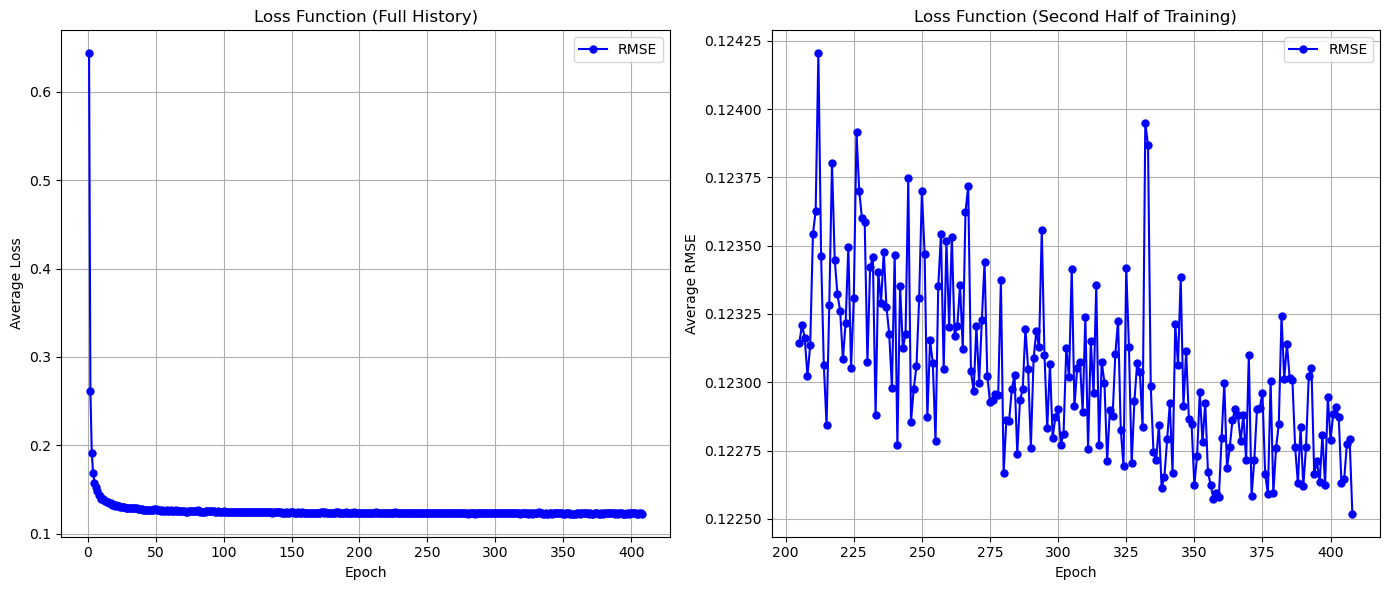

In [263]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history)

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [251]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.122519


Как и видим, что большое количество параметров `572 млн` (`572 603 394`) не принесли значимого результата по сравнению с минимальным количеством параметров

### №2

In [252]:
# Пример использования
log_file = "logs/logs_09102024_1.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=1024, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=1024, out_features=4096, bias=True)
(1): Linear(in_features=4096, out_features=4096, bias=True)
(2): Linear(in_features=4096, out_features=8192, bias=True)
(3): Linear(in_features=8192, out_features=4096, bias=True)
(4): Linear(in_features=4096, out_features=1024, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=1024, out_features=4096, bias=True)
(1): Identity()
(2): Linear(in_features=4096, out_features=8192, bias=True)
(3): Linear(in_features=8192, out_features=4096, bias=True)
(4): Linear(in_features=4096, out_features=1024, bias=True)
)
(ode_func): ODEFunc(
(fc1): Linear(in_features=1024, out_features=1024, bias=True)
(fc2): Linear(in_features=1024, out_features=1024, bias=True)
(relu): ReLU()
(norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)
(output_layer): Linear(in_features=1024, out_features=2, bias=True)

Total training time: 43140.0 seconds


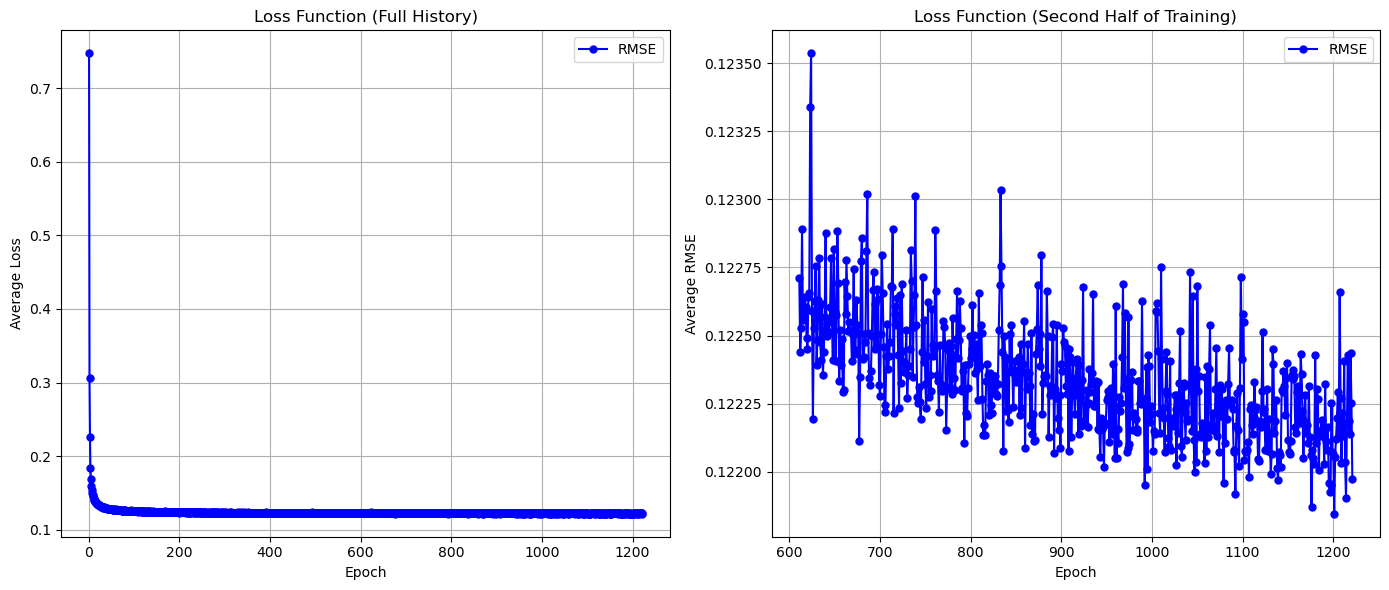

In [253]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history)

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [254]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.121846


Как и видим, что большое количество параметров `169 млн` (`169 917 442`) не принесли значимого результата по сравнению с минимальным количеством параметров

### №3

In [255]:
# Пример использования
log_file = "logs/logs_09102024_2.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=32, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=32, out_features=64, bias=True)
(1): Linear(in_features=64, out_features=128, bias=True)
(2-4): 3 x Linear(in_features=128, out_features=128, bias=True)
(5): Linear(in_features=128, out_features=64, bias=True)
(6): Linear(in_features=64, out_features=32, bias=True)
(7): Linear(in_features=32, out_features=16, bias=True)
(8): Linear(in_features=16, out_features=8, bias=True)
(9): Linear(in_features=8, out_features=4, bias=True)
(10): Linear(in_features=4, out_features=2, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=32, out_features=64, bias=True)
(1): Linear(in_features=64, out_features=128, bias=True)
(2-4): 3 x Identity()
(5): Linear(in_features=128, out_features=64, bias=True)
(6): Linear(in_features=64, out_features=32, bias=True)
(7): Linear(in_features=32, out_features=16, bias=True)
(8): Linear(in_features=16, out_featur

Total training time: 3093 seconds


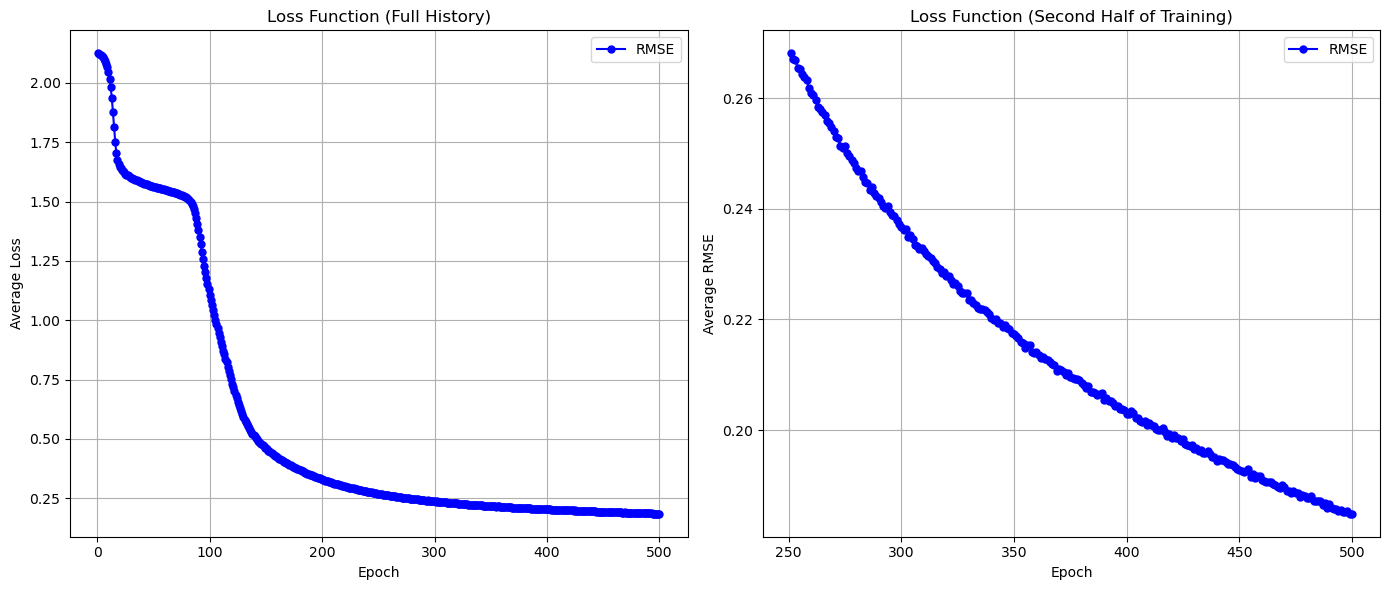

In [256]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history)

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [257]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.184879


Как и видим, что небольшое количество параметров `92 тыс` (`92 610`) не особо внушает качеством обучения

### №4

In [242]:
# Пример использования
log_file = "logs/logs_09102024_3.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=32, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=32, out_features=64, bias=True)
(1): Linear(in_features=64, out_features=128, bias=True)
(2): Linear(in_features=128, out_features=128, bias=True)
(3): Linear(in_features=128, out_features=64, bias=True)
(4): Linear(in_features=64, out_features=32, bias=True)
(5): Linear(in_features=32, out_features=8, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=32, out_features=64, bias=True)
(1): Linear(in_features=64, out_features=128, bias=True)
(2): Identity()
(3): Linear(in_features=128, out_features=64, bias=True)
(4): Linear(in_features=64, out_features=32, bias=True)
(5): Linear(in_features=32, out_features=8, bias=True)
)
(ode_func): ODEFunc(
(fc1): Linear(in_features=8, out_features=8, bias=True)
(fc2): Linear(in_features=8, out_features=8, bias=True)
(relu): ReLU()
(norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
)
(out

Total training time: 3366 seconds


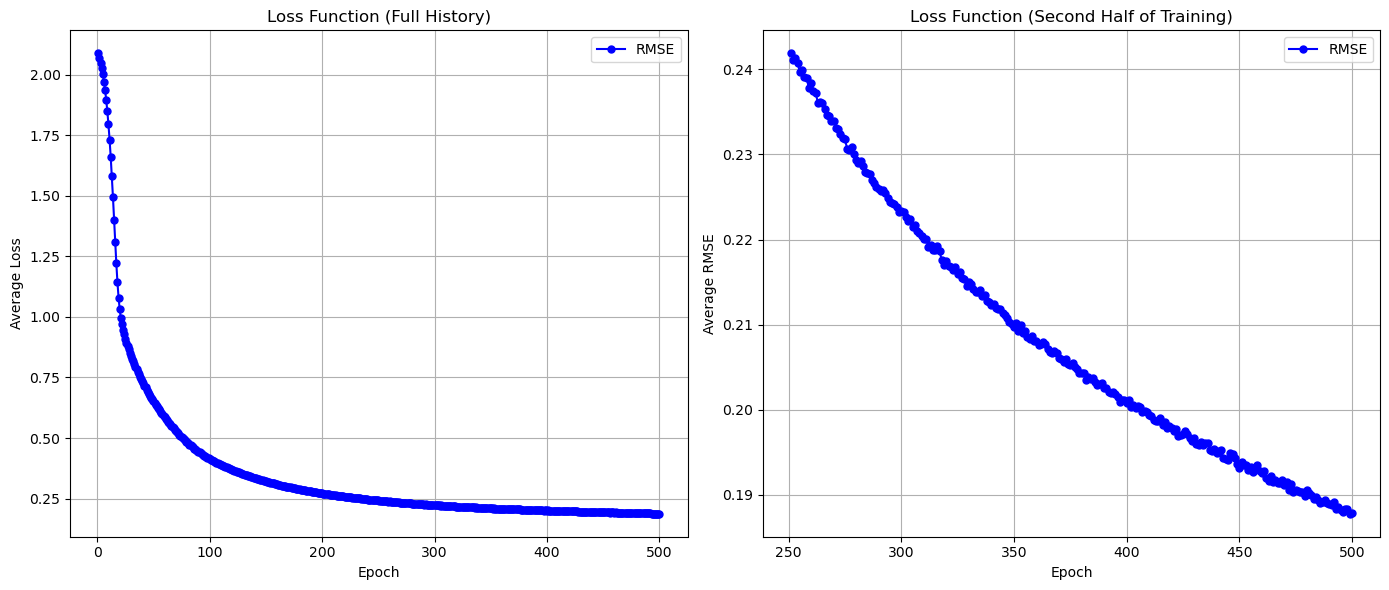

In [243]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history)

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [244]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.187783


Как и видим, что небольшое количество параметров `58 тыс` (`58 850`) также не принесли внушительного результата

## Результаты

In [246]:
df_results

,Total parameters,RMSE,Training time (s)
0,572603394,0.122519,43203.0
1,169917442,0.121846,43187.0
2,92610,0.184879,3093.0
3,58850,0.187783,3366.0
4,58850,0.187783,NaN
